In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = max(0.1, min(Imax, 10))  # Bounds for Imax
        self.Sumax = max(10, min(Sumax, 1000))  # Bounds for Sumax
        self.Qsmax = max(1, min(Qsmax, 100))  # Bounds for Qsmax
        self.aE = max(0, min(aE, 100))  # Bounds for aE
        self.aF = max(-10, min(aF, 10))  # Bounds for aF
        self.Kf = max(0.1, min(Kf, 10))  # Bounds for Kf
        self.Ks = max(1, min(Ks, 150))  # Bounds for Ks

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Example parameters within the given range
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions
initial_conditions = np.ones(5) * 1e-6

# Define the model
def crr_model(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)  # Ensure the index is within bounds
    # Model equations
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * y[0] / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * y[1] / params.Sumax, params.Qsmax)
    dS_slow = params.aF * y[1] / params.Sumax - y[2] / params.Ks
    dS_fast = (y[1] - dS_unsat) - y[3] / params.Kf
    Q_runoff = y[2] / params.Ks + y[3] / params.Kf
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(crr_model, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

# Remove the first two years (730 days)
P = rainfall[730:]
Ep = evaporation[730:]
Y_sim = Q_sim[730:]
Y_obs = discharge[730:]

# Calculate objective functions
F1 = calculate_rmse(Y_sim, Y_obs, P > 0)
F2 = calculate_rmse(Y_sim, Y_obs, P == 0)

F = [F1, F2]
print("Objective functions:", F)


Objective functions: [2693678.92081628, 2690911.7727942984]


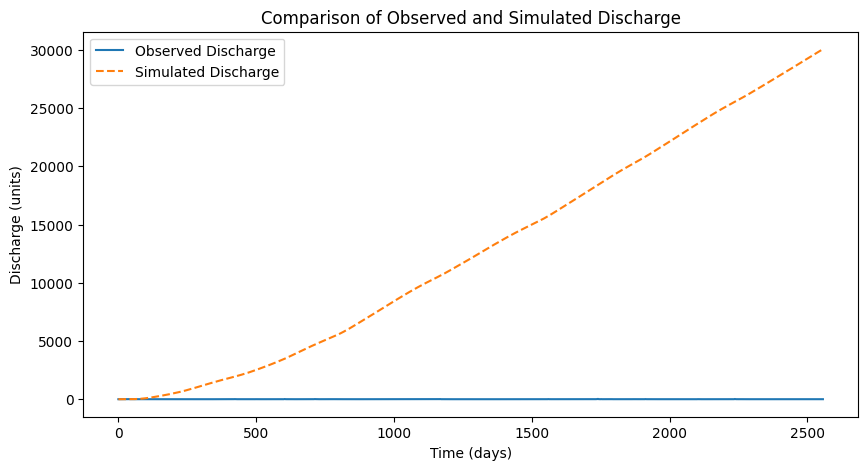

In [3]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = max(0.1, min(Imax, 10))  # Ensuring bounds
        self.Sumax = max(10, min(Sumax, 1000))
        self.Qsmax = max(1, min(Qsmax, 100))
        self.aE = max(0, min(aE, 100))
        self.aF = max(-10, min(aF, 10))
        self.Kf = max(0.1, min(Kf, 10))
        self.Ks = max(1, min(Ks, 150))

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

# Example parameters within the given range
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions
initial_conditions = np.ones(5) * 1e-2

def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Plot observed vs simulated discharge
plt.figure(figsize=(10, 5))
plt.plot(discharge, label='Observed Discharge')
plt.plot(Q_sim, label='Simulated Discharge', linestyle='--')
plt.title('Comparison of Observed and Simulated Discharge')
plt.xlabel('Time (days)')
plt.ylabel('Discharge (units)')
plt.legend()
plt.show()


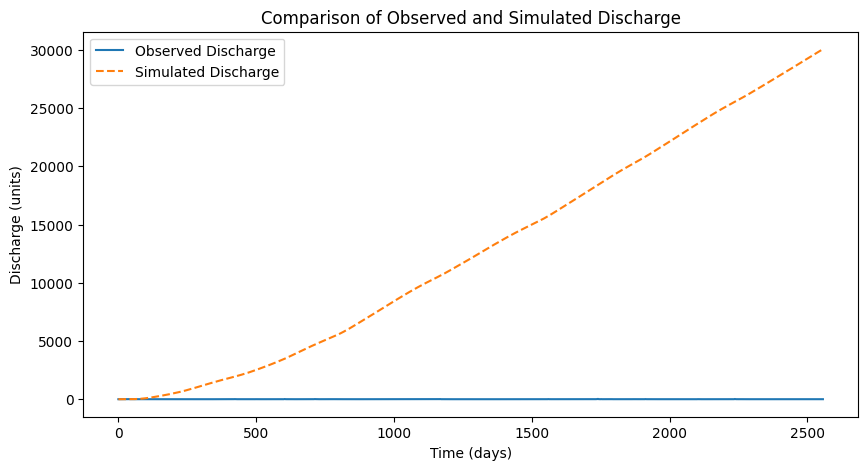

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

# Initialize parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Define the model
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]

    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Simulation setup
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))
initial_conditions = np.ones(5) * 1e-2

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Plotting results
plt.figure(figsize=(10, 5))
plt.plot(discharge, label='Observed Discharge')
plt.plot(solution.y[4], label='Simulated Discharge', linestyle='--')
plt.title('Comparison of Observed and Simulated Discharge')
plt.xlabel('Time (days)')
plt.ylabel('Discharge (units)')
plt.legend()
plt.show()


Optimal parameters: [7.06940719e+00 2.12095219e+01 3.78932207e+01 1.99202652e-07
 1.20439985e-01 7.00731868e+00 8.08092396e+01]
Objective function value: 3.3422656205572654


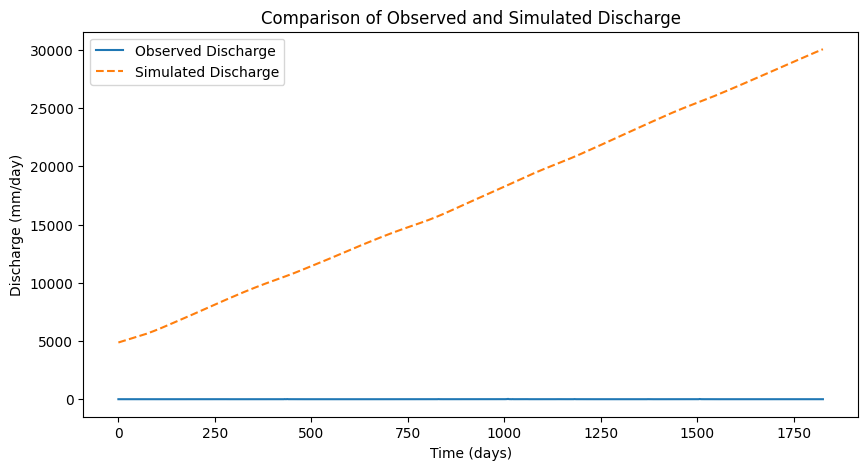

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions
initial_conditions = np.ones(5) * 1e-2

# Define the model function
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    # Model equations
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * y[0] / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * y[1] / params.Sumax, params.Qsmax)
    dS_slow = params.aF * y[1] / params.Sumax - y[2] / params.Ks
    dS_fast = (y[1] - dS_unsat) - y[3] / params.Kf
    Q_runoff = y[2] / params.Ks + y[3] / params.Kf
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

def objective_function(x):
    params = ModelParameters(*x)
    solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
    Q_sim = solution.y[4]
    Y_sim = Q_sim[730:]
    Y_obs = discharge[730:]
    P = rainfall[730:]
    F1 = calculate_rmse(Y_sim, Y_obs, P > 0)
    F2 = calculate_rmse(Y_sim, Y_obs, P == 0)
    return F1 + F2  # Single scalar objective function

# Parameter bounds
bounds = [(1, 10), (10, 1000), (0, 100), (0, 1), (0, 1), (0.1, 10), (0.1, 150)]

# Perform Differential Evolution
result = differential_evolution(objective_function, bounds, popsize=20, maxiter=50)

print("Optimal parameters:", result.x)
print("Objective function value:", result.fun)

# Plotting the discharge comparison
plt.figure(figsize=(10, 5))
plt.plot(discharge[730:], label='Observed Discharge')
plt.plot(Q_sim[730:], label='Simulated Discharge', linestyle='--')
plt.title('Comparison of Observed and Simulated Discharge')
plt.xlabel('Time (days)')
plt.ylabel('Discharge (mm/day)')
plt.legend()
plt.show()

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Initial example parameters
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions
initial_conditions = np.ones(5) * 1e-2

# Define the model function
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    # Model equations
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * y[0] / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * y[1] / params.Sumax, params.Qsmax)
    dS_slow = params.aF * y[1] / params.Sumax - y[2] / params.Ks
    dS_fast = (y[1] - dS_unsat) - y[3] / params.Kf
    Q_runoff = y[2] / params.Ks + y[3] / params.Kf
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

def objective_function(x):
    params = ModelParameters(*x)
    solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
    Q_sim = solution.y[4]
    Y_sim = Q_sim[730:]
    Y_obs = discharge[730:]
    P = rainfall[730:]
    F1 = calculate_rmse(Y_sim, Y_obs, P > 0)
    F2 = calculate_rmse(Y_sim, Y_obs, P == 0)
    return F1 + F2  # Single scalar objective function

# Parameter bounds
bounds = [(1, 10), (10, 1000), (0, 100), (0, 1), (0, 1), (0.1, 10), (0.1, 150)]

# Perform Differential Evolution
result = differential_evolution(objective_function, bounds, popsize=20, maxiter=50)

print("Optimal parameters:", result.x)
print("Objective function value:", result.fun)

Optimal parameters: [8.12085628e+00 1.51402835e+01 8.39173512e+01 3.69006225e-07
 8.44275887e-02 7.47332467e+00 8.88137459e+01]
Objective function value: 3.3433504948093185
